In [ ]:
import time

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import cupy as cp

import ducc0
from delensalot.sims.sims_lib import Xunl, Xsky, Xobs
from lenspyx import cachers
import cunusht

mode = 'SHT'

def get_toydata(lmax=1024, mmax=1024, geominfo=('gl',{'lmax': 1024})):
    ll = np.arange(0,lmax)
    # geominfo = ('gl',{'lmax': lmax})
    # geominfo = ('healpix',{'nside': 512})

    synunl = Xunl(lmax=lmax, geominfo=geominfo)
    synsky = Xsky(lmax=lmax, unl_lib=synunl, geominfo=geominfo)

    philm = synunl.get_sim_phi(0, space='alm')
    dlm = hp.almxfl(philm, np.sqrt(ll*(ll+1)))

    Tunl = synunl.get_sim_unl(0, spin=0, space='alm', field='temperature')
    # Tsky = synsky.get_sim_sky(0, spin=0, space='map', field='temperature')

    return Tunl, dlm, philm
# int(t.geom.nph[0]/2-1)


def synthesis(t, Tunl, solver, lmax):
    defres = t.synthesis(Tunl.copy(), lmax=lmax, mmax=lmax, spin=0, nthreads=4)
    return defres

solvers = ['ducc', 'shtns']

In [ ]:
solver = 'shtns'
mode = 'SHT'
backend = 'GPU'
t = cunusht.get_transformer(solver, mode, backend)

bm_GPU = []
for lmax in 256*np.arange(1,16):
    mmax = lmax
    geominfo = ('gl',{'lmax': lmax})
    t.set_geometry(geominfo)

    Tunl, dlm, philm = get_toydata(lmax, mmax, geominfo)
    result = %timeit -o -n1 -r1 synthesis(t, Tunl, solver, lmax)
    bm_GPU.append([lmax, result])
    

In [ ]:
solver = 'ducc'
backend = 'CPU'
mode = 'SHT'
t = cunusht.get_transformer(solver, mode, backend)

if 'defres' in locals():
    defres = np.array(defres)
    ptg = np.array(ptg)
    map_dfs = np.array(map_dfs)

bm_CPU = []
for lmax in 256*np.arange(1,16):
    mmax = lmax
    geominfo = ('gl',{'lmax': lmax})
    t.set_geometry(geominfo)

    Tunl, dlm, philm = get_toydata(lmax, mmax, geominfo)
    result = %timeit -o -n1 -r1 synthesis(t, Tunl, solver, lmax)
    bm_CPU.append([lmax, result])

In [ ]:
solver = 'shtns'
backend = 'CPU'
t = cunusht.get_transformer(solver, mode, backend)


if 'defres' in locals():
    defres = np.array(defres)
    ptg = np.array(ptg)
    map_dfs = np.array(map_dfs)

bm_CPU_shtns = []
for lmax in 256*np.arange(1,16):
    geominfo = ('gl',{'lmax': lmax, 'mmax':lmax})
    t.set_geometry(geominfo)

    Tunl, dlm, philm = get_toydata(lmax, mmax, geominfo)
    result = %timeit -o -n1 -r1 synthesis(t, Tunl, solver, lmax)
    bm_CPU_shtns.append([lmax, result])

In [ ]:
solver = 'shtns'
backend = 'CPU'
mode='SHT'
lmax = 1000
import cunusht
t = cunusht.get_transformer(solver, mode, backend)
geominfo_ = ('gl',{'lmax': lmax, 'mmax': lmax})
t.set_geometry(geominfo_)
t.constructor.print_info()

In [ ]:
solver = 'shtns'
backend = 'GPU'
mode='SHT'
lmax = 1000
import cunusht
t = cunusht.get_transformer(solver, mode, backend)
geominfo_ = ('gl',{'lmax': lmax})
t.set_geometry(geominfo_)
t.constructor.print_info()

In [ ]:
plt.plot([bC[0] for bC in bm_CPU], [bC[1].average for bC in bm_CPU], label='ducc')
plt.plot([bG[0] for bG in bm_GPU], [bG[1].average for bG in bm_GPU], label='GPU shtns')
plt.plot([bC[0] for bC in bm_CPU_shtns], [bC[1].average for bC in bm_CPU_shtns], label='CPU shtns')
plt.legend()
plt.ylabel('time (s)')
plt.xlabel('lmax')
plt.title('SHT time for different lmax')

In [ ]:
plt.plot([bC[0] for bC in bm_CPU], [bC[1].average/bG[1].average for bC, bG in zip(bm_CPU, bm_GPU)], label='fi/cufinufft')
plt.plot([bC[0] for bC in bm_CPU], [bC[1].average/bG[1].average for bC, bG in zip(bm_CPU_ducc, bm_GPU)], label='ducc/cufinufft')
plt.legend()
# plt.plot([bG[0] for bG in bm_GPU], [bG[1].average for bG in bm_GPU], label='cufinufft')
# plt.plot([bC[0] for bC in bm_CPU_ducc], [bC[1].average for bC in bm_CPU_ducc], label='duccnufft')
plt.title('speedup')

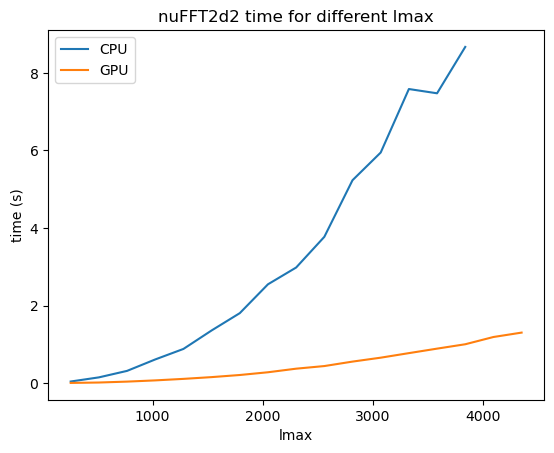